# Start to Finish

# Imports

In [1]:
%matplotlib inline
import librosa, librosa.display
import numpy as np
import random 
import os
import matplotlib.pyplot as plt
import math
from spleeter.separator import Separator

import moviepy.editor as mp
from PIL import Image

from datetime import datetime

start = datetime.now()

2023-03-15 17:17:57.603572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.set_printoptions(linewidth=10000, suppress=True)

# Params

In [105]:
DRUM_AUDIO_PATH = '../raw_data/audio/Drums.wav'
audio_path = '../raw_data/audio/Drums.wav'
AUDIO_FILE_NAME = 'Drums.wav'
RAW_AUDIO_PATH = '../raw_data/audio/Drums.wav'


In [34]:
# IO
# AUDIO_FILE_NAME = RAW_AUDIO_PATH.split('/')[-1].split('.')[0]

# SPLIT_AUDIO_PATH = f"../raw_data/audio/{AUDIO_FILE_NAME}/"
# DRUM_AUDIO_PATH = f"{SPLIT_AUDIO_PATH}{AUDIO_FILE_NAME}-drums.wav"

VIDEO_SAVE_NAME = f"{AUDIO_FILE_NAME}-asha.mp4"
VIDEO_SAVE_PATH = f"../outputs/{VIDEO_SAVE_NAME}"

# GLOBAL
# FIXED DURATION

# AUDIO 
FRAME_RATE = 60
HOP_WINDOW = 512

# Images
IMAGE_TIME_GAP = 2 # seconds, play with this
IMAGE_FRAME_GAP = IMAGE_TIME_GAP * FRAME_RATE

# VIDEO
MAX_VIDEO_DURATION = 8

# Audio

## Split the Audio into stems

With spleeter by deezer

In [35]:
# seperator = Separator(params_descriptor='spleeter:4stems')

# seperator.separate_to_file(
#     RAW_AUDIO_PATH, 
#     SPLIT_AUDIO_PATH,
#     duration=MAX_VIDEO_DURATION,
#     filename_format="{filename}-{instrument}.{codec}"
# )

## Extracting Audio info from drum stem

### Extraction functions

In [36]:
def get_audio_params(audio_path):
    # Load song with 22050 sample rate
    y, sr = librosa.load(audio_path, sr=22050)
    audio_duration = librosa.get_duration(y, sr=sr)
    
    total_frames_float = audio_duration * FRAME_RATE
    total_frames = math.ceil(total_frames_float)
    
    sample_rate = round(total_frames_float / audio_duration * HOP_WINDOW)
    
    return total_frames, sample_rate, audio_duration

In [37]:
def get_onset_info(audio_path, sample_rate):
    # Load
    y, sr = librosa.load(audio_path, sr=sample_rate)
    
    # Onset strengths and normalize
    onset_strengths = librosa.onset.onset_strength(y=y, sr=sample_rate, aggregate=np.median)
    onset_strengths = librosa.util.normalize(onset_strengths)
    
    # Onset timestamps and frames
    onset_times = librosa.times_like(onset_strengths, sr=sample_rate)
    onset_frames = onset_times * FRAME_RATE
    
    onset_info = np.concatenate([
        onset_frames.reshape((-1, 1)),
        onset_times.reshape((-1, 1)),
        onset_strengths.reshape((-1, 1))
    ], axis=1)
    
    # Beat times
    beat_times = librosa.beat.beat_track(y=y, sr=sample_rate, units='time')[1]
    
    return y, onset_info, beat_times

### Using those functions

In [38]:
total_frames, sample_rate, audio_duration = get_audio_params(DRUM_AUDIO_PATH)
total_frames, sample_rate, audio_duration

(501, 30720, 8.347845804988662)

In [39]:
y, onset_info, beat_times = get_onset_info(DRUM_AUDIO_PATH, sample_rate)
y.shape, onset_info.shape, beat_times.shape

((256446,), (501, 3), (14,))

In [40]:
onset_info

array([[  0.        ,   0.        ,   0.        ],
       [  1.        ,   0.01666667,   0.        ],
       [  2.        ,   0.03333333,   0.        ],
       ...,
       [498.        ,   8.3       ,   0.        ],
       [499.        ,   8.31666667,   0.        ],
       [500.        ,   8.33333333,   0.00496177]])

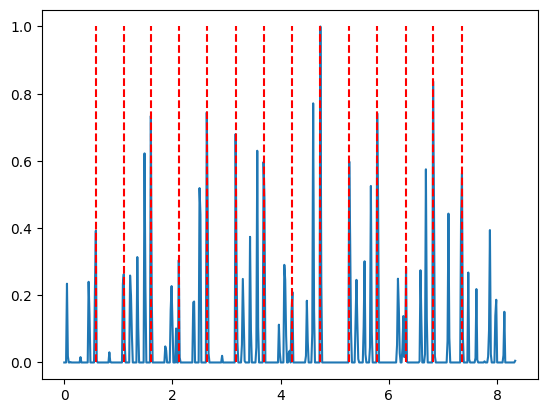

In [41]:
plt.plot(onset_info[:,1], onset_info[:,2])
plt.vlines(beat_times, ymin=0, ymax=1, colors='r', linestyles='--')
plt.show()

## Create additional onset strength features

- Linear Decay
- Exponential Decay

In [42]:
def create_onset_features(onset_info, beat_times, lin_decay_time=0.9, exp_decay_rate=40, decay_magnification=True):
    
    fixed_decay_frames = int(lin_decay_time * FRAME_RATE)
    
    # Create column of zeroes as default value for both Linear and Exp Decay
    onset_info = np.concatenate([onset_info, np.zeros((onset_info.shape[0], 1)), np.zeros((onset_info.shape[0], 1))], axis=1)
    
    # for each row
    for i in range(onset_info.shape[0]):
        # Skip the first value, makes life easy
        if i == 0:
            onset_info[i, 3] = 0
        
        
        ## LINEAR
        # If the timestamp is in beat_times, it's a peak
        if onset_info[i, 1] in beat_times:
            onset_info[i, 3] = onset_info[i, 2] # Linear Column
            
            # Decay Params
            decay_factor = 1
            if decay_magnification:
                decay_factor *= (onset_info[i, 2] + 1)
            
            decay_frames = fixed_decay_frames * decay_factor
            lin_decay_val = onset_info[i, 2] / decay_frames
        
        # Check if the previous value is zero or less than the decay_val -> 0
        if onset_info[i - 1, 3] == 0. or abs(onset_info[i -1, 3]) < lin_decay_val:
            pass
        
        # If previous value > 0, needs decay
        elif onset_info[i - 1, 3] > 0: 
            onset_info[i, 3] = onset_info[i - 1, 3] - lin_decay_val
        
        
        # EXPONENTIAL
        # If the timestamp is in beat_times, it's a peak
        if onset_info[i, 1] in beat_times:
            onset_info[i, 4] = onset_info[i, 2] # Exp Column
        
        # Set current to zero if previous is zero or small number
        elif onset_info[i - 1, 4] == 0 or onset_info[i - 1, 4] < 0.005: 
            pass
        
        # If previous value > 0, needs decay
        elif onset_info[i - 1, 4] != 0: 
                onset_info[i, 4] = onset_info[i - 1, 4] * (1 - exp_decay_rate)
    
    return onset_info

In [43]:
y, onset_info, beat_times = get_onset_info(DRUM_AUDIO_PATH, sample_rate)
onset_info = create_onset_features(onset_info, beat_times, lin_decay_time=0.25, exp_decay_rate=0.25, decay_magnification=False)

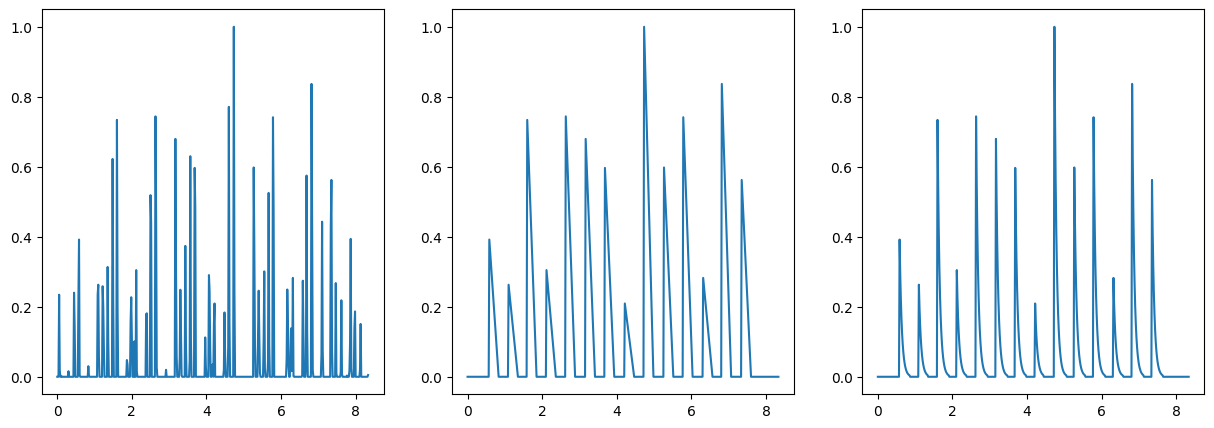

In [44]:
# Visualising

fig, ax = plt.subplots(nrows=1, ncols=3)

fig.set_figheight(5)
fig.set_figwidth(15)

ax[0].plot(onset_info[:,1], onset_info[:,2])
# ax[0].vlines(beat_times, ymin=0, ymax=1, colors='r', linestyles='--')
ax[1].plot(onset_info[:,1], onset_info[:,3])
# ax[1].vlines(beat_times, ymin=0, ymax=1, colors='r', linestyles='--')
ax[2].plot(onset_info[:,1], onset_info[:,4])
# ax[2].vlines(beat_times, ymin=0, ymax=1, colors='r', linestyles='--')

plt.show()

# Model Stuff

In [45]:
import numpy as np
from PIL import Image
import os

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Reshape, Conv2D, Conv2DTranspose, Dense, Flatten, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory

In [46]:
ds = image_dataset_from_directory('../raw_data/zelle', label_mode=None, image_size=(448, 448), batch_size=16)

Found 2360 files belonging to 1 classes.


In [47]:
ds = ds.map(lambda x: x/255)

In [48]:
imgs = ds.as_numpy_iterator().__next__()
imgs.shape

(16, 448, 448, 3)

### Model Architecture

Because we are using load weights, we need to instantiate the model every time. This sucks for notebooks, but it will be fine once everything is packaged.

In [49]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [50]:
latent_dim = 200

## Encoder

input_image = Input(shape=(448, 448, 3))
    
x = Conv2D(32, (3, 3), padding='same', activation="relu")(input_image)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

# Encoder Build
encoder = Model(input_image, [z_mean, z_log_var, z], name="encoder")

#############################################

## Decoder

latent_inputs = Input(shape=(latent_dim,))  
y = Dense(7*7*128, activation='tanh')(latent_inputs)
y = Reshape((7, 7, 128))(y)

y = Conv2DTranspose(256, (3, 3), strides=2, padding='same', activation="relu")(y)
y = Conv2DTranspose(256, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(256, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(256, (3, 3), strides=1, padding='same', activation="relu")(y)

y = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation="relu")(y)
y = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(y)

y = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation="relu")(y)
y = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(y)

y = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation="relu")(y)
y = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(y)

y = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation="relu")(y)
y = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(y)
y = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(y)

decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(y)

# Decoder Build
decoder = Model(inputs=latent_inputs, outputs=decoder_output, name="decoder")

In [51]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Instantiate Model and Load weights

In [52]:
vae = VAE(encoder, decoder)

vae.load_weights('../saved_models/e5100/vae_complex_model_epoch5100')

### Predict

FIX ME FIX ME FIX ME FIX ME FIX ME FIX ME FIX ME FIX ME FIX ME FIX ME FIX ME FIX ME

Save latent vectors for ALL images into a numpy array and pickle it. Then it would be easy to load and randomly select vectors.

In [53]:
# foldername = '../raw_data/zelle'

# def load_images_from_folder(foldername, output_folder):
#     latent_space = []
#     for filename in os.listdir(foldername):
#         with Image.open(os.path.join(foldername,filename)).resize((448,448)) as img:
#             if img is not None:
#                 img = np.asarray(img)
#                 encoded = vae.encoder(img.reshape(-1,448,448,3)/255)
#                 latent_space.append(encoded[2])
#     latent_space = np.concatenate(latent_space, axis=0)
#     np.save('encoded_images.npy', latent_space)
#     return latent_space

# load_images_from_folder(foldername, foldername)

In [54]:
filename = "encoded_images_npy"

def load_images_from_file(filename):
    latent_space = np.load(filename)
    return latent_space

In [74]:
N_IMAGES = math.ceil(audio_duration / IMAGE_TIME_GAP + 1)
N_IMAGES

6

In [93]:
encoded_images = load_images_from_file("encoded_images.npy")

In [90]:
#encoded_images = vae.decoder.predict(encoded_images[0:3 + N_IMAGES])[2]

1/1 [==============================] - 0s 491ms/step


In [94]:
encoded_images.shape

(2360, 200)

In [95]:
random_start_point = np.random.randint(0, encoded_images.shape[0] - N_IMAGES, size=(1))[0]
random_start_point

1087

# Create Interpolated Images

In [96]:
def create_interp_vecs(N_IMAGES, encoded_images, min_factor=12, onset_info=onset_info):
    # Empty lists to append new vectors to
    lin_interp_vecs = []
    exp_interp_vecs = []
    
    # We want to interate through the images to be able to interpolate between them
    for i in range(N_IMAGES - 1):
        
        # Get start and stop latent vectors
        start_vec = encoded_images[i]
        end_vec = encoded_images[i + 1]
        
        # get step_vec between image_n and image_n + 1
        step_vec = (end_vec - start_vec) / IMAGE_FRAME_GAP
            
        # We now need to create an image at every frame 
        # Mad props to Charlotte for making this way simpler than I was trying to make it
        for j in range(IMAGE_FRAME_GAP):
            
            current_frame = IMAGE_FRAME_GAP * i + j
            # Check to see if current_frame > total_frames : no point making extra images
            if current_frame > int(onset_info[-1,0]):
                break
            lin_interp_vecs.append(start_vec + (step_vec * j * (onset_info[current_frame, 3] / min_factor + 1)))
            exp_interp_vecs.append(start_vec + (step_vec * j * (onset_info[current_frame, 4] / min_factor + 1)))
            
    return np.array(lin_interp_vecs), np.array(exp_interp_vecs)

In [97]:
lin_interp_vecs, exp_interp_vecs = create_interp_vecs(N_IMAGES, encoded_images, min_factor=1, onset_info=onset_info)

In [98]:
lin_interp_vecs.shape, exp_interp_vecs.shape

((501, 200), (501, 200))

In [101]:
def create_interp_imgs(decoder, lin_interp_vecs=lin_interp_vecs, exp_interp_vecs=exp_interp_vecs):
    # Linear Images
    lin_interp_imgs = decoder.predict(lin_interp_vecs)
    lin_interp_imgs = (lin_interp_imgs * 255).astype('uint8')
    
    # Exponential Images
    exp_interp_imgs = decoder.predict(exp_interp_vecs)
    exp_interp_imgs = (exp_interp_imgs * 255).astype('uint8')
    
    return lin_interp_imgs, exp_interp_imgs

In [100]:
lin_imgs, exp_imgs = create_interp_imgs(vae.decoder, lin_interp_vecs=lin_interp_vecs, exp_interp_vecs=exp_interp_vecs)

16/16 [==============================] - 25s 2s/step


# Create AV

In [106]:
def create_video_with_audio(interp_imgs):
    
    # Load the audio file
    audio_clip = mp.AudioFileClip(RAW_AUDIO_PATH).set_duration(MAX_VIDEO_DURATION)
    
    # Needed for some reason?
    frames = [mp.ImageClip(interp_img).set_duration(1/FRAME_RATE) for interp_img in interp_imgs]
    
    # Combine the frames into a video clip
    video_clip = mp.concatenate_videoclips(frames, method='chain')
    
    # Overlay the audio on the video clip
    final_clip = video_clip.set_audio(audio_clip)
    
    # Write the final video clip to file
    final_clip.write_videofile(VIDEO_SAVE_PATH, fps=FRAME_RATE)

In [107]:
VIDEO_SAVE_PATH

'../outputs/Drums.wav-asha.mp4'

In [108]:
create_video_with_audio(exp_imgs)

Moviepy - Building video ../outputs/Drums.wav-asha.mp4.
MoviePy - Writing audio in Drums.wav-ashaTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ../outputs/Drums.wav-asha.mp4



Moviepy - Done !
Moviepy - video ready ../outputs/Drums.wav-asha.mp4


In [152]:
print(datetime.now() - start)

0:12:31.370209
